In [13]:
import torch, os, cv2
import torch.nn as nn
import torchvision.transforms as T
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")
print('GPU') if str(device) == "cuda:0" else print('GPU not Detected - CPU Selected')
print(f"GPUs Count: {torch.cuda.device_count()}")

GPU
GPUs Count: 1


#### **ESPNet Model**

In [14]:
'''
### Code Reference: https://github.com/sacmehta/ESPNet
'''

class CBR(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1):
        super().__init__()
        padding = int((kSize - 1)/2)
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False)
        self.bn = nn.BatchNorm2d(nOut, eps=1e-03)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        output = self.act(output)
        return output

class BR(nn.Module):
    def __init__(self, nOut):
        super().__init__()
        self.bn = nn.BatchNorm2d(nOut, eps=1e-03)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        output = self.bn(input)
        output = self.act(output)
        return output

class CB(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1):
        super().__init__()
        padding = int((kSize - 1)/2)
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False)
        self.bn = nn.BatchNorm2d(nOut, eps=1e-03)

    def forward(self, input):
        output = self.conv(input)
        output = self.bn(output)
        return output

class C(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1):
        super().__init__()
        padding = int((kSize - 1)/2)
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False)

    def forward(self, input):
        output = self.conv(input)
        return output

class CDilated(nn.Module):
    def __init__(self, nIn, nOut, kSize, stride=1, d=1):
        super().__init__()
        padding = int((kSize - 1)/2) * d
        self.conv = nn.Conv2d(nIn, nOut, (kSize, kSize), stride=stride, padding=(padding, padding), bias=False, dilation=d)

    def forward(self, input):
        output = self.conv(input)
        return output

class DownSamplerB(nn.Module):
    def __init__(self, nIn, nOut):
        super().__init__()
        n = int(nOut/5)
        n1 = nOut - 4*n
        self.c1 = C(nIn, n, 3, 2)
        self.d1 = CDilated(n, n1, 3, 1, 1)
        self.d2 = CDilated(n, n, 3, 1, 2)
        self.d4 = CDilated(n, n, 3, 1, 4)
        self.d8 = CDilated(n, n, 3, 1, 8)
        self.d16 = CDilated(n, n, 3, 1, 16)
        self.bn = nn.BatchNorm2d(nOut, eps=1e-3)
        self.act = nn.PReLU(nOut)

    def forward(self, input):
        output1 = self.c1(input)
        d1 = self.d1(output1)
        d2 = self.d2(output1)
        d4 = self.d4(output1)
        d8 = self.d8(output1)
        d16 = self.d16(output1)
        add1 = d2
        add2 = add1 + d4
        add3 = add2 + d8
        add4 = add3 + d16
        combine = torch.cat([d1, add1, add2, add3, add4],1)
        output = self.bn(combine)
        output = self.act(output)
        return output

class DilatedParllelResidualBlockB(nn.Module):
    def __init__(self, nIn, nOut, add=True):
        super().__init__()
        n = int(nOut/5)
        n1 = nOut - 4*n
        self.c1 = C(nIn, n, 1, 1)
        self.d1 = CDilated(n, n1, 3, 1, 1)  # dilation rate of 2^0
        self.d2 = CDilated(n, n, 3, 1, 2)   # dilation rate of 2^1
        self.d4 = CDilated(n, n, 3, 1, 4)   # dilation rate of 2^2
        self.d8 = CDilated(n, n, 3, 1, 8)   # dilation rate of 2^3
        self.d16 = CDilated(n, n, 3, 1, 16) # dilation rate of 2^4
        self.bn = BR(nOut)
        self.add = add

    def forward(self, input):
        output1 = self.c1(input)
        d1 = self.d1(output1)
        d2 = self.d2(output1)
        d4 = self.d4(output1)
        d8 = self.d8(output1)
        d16 = self.d16(output1)
        add1 = d2
        add2 = add1 + d4
        add3 = add2 + d8
        add4 = add3 + d16
        combine = torch.cat([d1, add1, add2, add3, add4], 1)
        if self.add:
            combine = input + combine
        output = self.bn(combine)
        return output

class InputProjectionA(nn.Module):
    def __init__(self, samplingTimes):
        super().__init__()
        self.pool = nn.ModuleList()
        for i in range(0, samplingTimes):
            self.pool.append(nn.AvgPool2d(3, stride=2, padding=1))

    def forward(self, input):
        for pool in self.pool:
            input = pool(input)
        return input

class ESPNet_Encoder(nn.Module):
    def __init__(self, channels, p, q):
        super().__init__()
        self.level1 = CBR(3, 16, 3, 2)
        self.sample1 = InputProjectionA(1)
        self.sample2 = InputProjectionA(2)
        self.b1 = BR(16 + 3)
        self.level2_0 = DownSamplerB(16 + 3, 64)
        self.level2 = nn.ModuleList()
        for i in range(0, p):
            self.level2.append(DilatedParllelResidualBlockB(64 , 64))
        self.b2 = BR(128 + 3)
        self.level3_0 = DownSamplerB(128 + 3, 128)
        self.level3 = nn.ModuleList()
        for i in range(0, q):
            self.level3.append(DilatedParllelResidualBlockB(128 , 128))
        self.b3 = BR(256)
        self.classifier = C(256, channels, 1, 1)

    def forward(self, input):
        output0 = self.level1(input)
        inp1 = self.sample1(input)
        inp2 = self.sample2(input)
        output0_cat = self.b1(torch.cat([output0, inp1], 1))
        output1_0 = self.level2_0(output0_cat)
        
        for i, layer in enumerate(self.level2):
            if i==0:
                output1 = layer(output1_0)
            else:
                output1 = layer(output1)

        output1_cat = self.b2(torch.cat([output1,  output1_0, inp2], 1))
        output2_0 = self.level3_0(output1_cat)
        for i, layer in enumerate(self.level3):
            if i==0:
                output2 = layer(output2_0)
            else:
                output2 = layer(output2)
        output2_cat = self.b3(torch.cat([output2_0, output2], 1))
        classifier = self.classifier(output2_cat)
        return classifier
        
class ESPNet(nn.Module):
    def __init__(self, channels=10, final_class=1, p=5, q=9):
        super().__init__()
        self.encoder = ESPNet_Encoder(channels, p, q)
        self.modules = []
        for i, m in enumerate(self.encoder.children()):
            self.modules.append(m)

        self.level3_C = C(128 + 3, channels, 1, 1)
        self.br = nn.BatchNorm2d(channels, eps=1e-03)
        self.conv = CBR(19 + channels, channels, 3, 1)
        self.up_l3 = nn.Sequential(nn.ConvTranspose2d(channels, channels, 2, stride=2, padding=0, output_padding=0, bias=False))
        self.combine_l2_l3 = nn.Sequential(BR(2*channels), DilatedParllelResidualBlockB(2*channels , channels, add=False))
        self.up_l2 = nn.Sequential(nn.ConvTranspose2d(channels, channels, 2, stride=2, padding=0, output_padding=0, bias=False), BR(channels))
        self.classifier = nn.ConvTranspose2d(channels, final_class, 2, stride=2, padding=0, output_padding=0, bias=False)

    def forward(self, input):
        output0 = self.modules[0](input)
        inp1 = self.modules[1](input)
        inp2 = self.modules[2](input)

        output0_cat = self.modules[3](torch.cat([output0, inp1], 1))
        output1_0 = self.modules[4](output0_cat)
        for i, layer in enumerate(self.modules[5]):
            if i == 0:
                output1 = layer(output1_0)
            else:
                output1 = layer(output1)

        output1_cat = self.modules[6](torch.cat([output1, output1_0, inp2], 1))
        output2_0 = self.modules[7](output1_cat)
        for i, layer in enumerate(self.modules[8]):
            if i == 0:
                output2 = layer(output2_0)
            else:
                output2 = layer(output2)

        output2_cat = self.modules[9](torch.cat([output2_0, output2], 1))
        output2_c = self.up_l3(self.br(self.modules[10](output2_cat)))
        output1_C = self.level3_C(output1_cat)
        comb_l2_l3 = self.up_l2(self.combine_l2_l3(torch.cat([output1_C, output2_c], 1)))
        concat_features = self.conv(torch.cat([comb_l2_l3, output0_cat], 1))
        classifier = self.classifier(concat_features)
        return classifier

model = ESPNet().to(device)

In [15]:
model = torch.load("DEEP_DETECT_Best_Model.pth", weights_only=False, map_location=torch.device('cuda'))   # Load DEEP_DETECT Best Model

#### **Select IMAGE_PAIR**

In [16]:
########################################### Select Image Pair

IMAGE_PAIR = "WALL"     ## Choices:     WALL    GRAF    BIKES    LEUVEN    UBC    DUSTY    SMOKY

########################################################################################################
if IMAGE_PAIR == "WALL":
    input_1 = "./wall/img1.ppm"
    input_2 = "./wall/img6.ppm"
elif IMAGE_PAIR =="GRAF":
    input_1 = "./graf/img1.ppm"
    input_2 = "./graf/img6.ppm"
elif IMAGE_PAIR =="BIKES":
    input_1 = "./bikes/img1.ppm"
    input_2 = "./bikes/img6.ppm"
elif IMAGE_PAIR =="LEUVEN":
    input_1 = "./leuven/img1.ppm"
    input_2 = "./leuven/img6.ppm"
elif IMAGE_PAIR =="UBC":
    input_1 = "./ubc/img1.ppm"
    input_2 = "./ubc/img6.ppm"
elif IMAGE_PAIR =="DUSTY":
    input_1 = "./dusty/img1.bmp"
    input_2 = "./dusty/img2.bmp"
elif IMAGE_PAIR =="SMOKY":
    input_1 = "./smoky/img1.bmp"
    input_2 = "./smoky/img2.bmp"

homo_file_name = "H1to" + input_2[-5] + "p"
homo_file_path = os.path.join(input_1[:-9], homo_file_name)

with open(homo_file_path, "r") as f:
    content = f.read()  # read entire file as string                
    HOMOGRAPHY_MATRIX = np.fromstring(content, sep=" ")
    my_HOMOGRAPHY = HOMOGRAPHY_MATRIX.reshape(-1, 3)
print(my_HOMOGRAPHY)

nndr_threshold = 0.99
my_threshold = 1.0
model_threshold = 0.5

[[ 2.58163100e-01  2.81222035e-02  1.22771933e+02]
 [-9.82734071e-02  9.03428086e-01  8.79736610e+01]
 [-4.09687068e-04  8.67484265e-07  1.00000000e+00]]


#### **Image Matching**

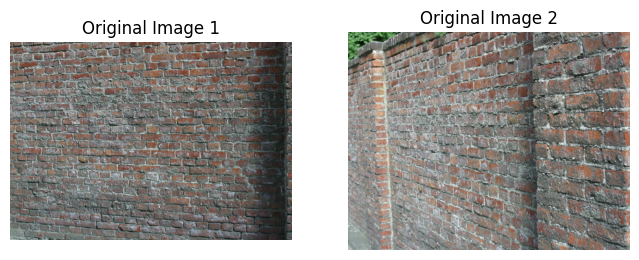

Image 1: 605433 keypoints, Image 2: 477060 keypoints


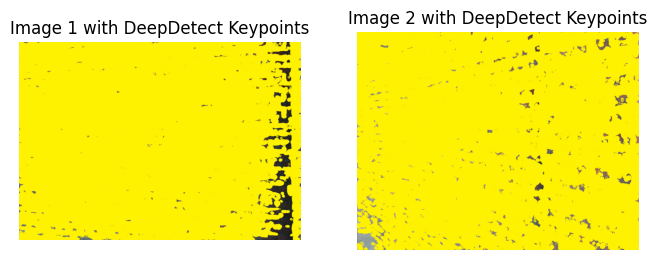

All NNDR Matches (479562 matches)
Correct Matches (4770 Correspondences)


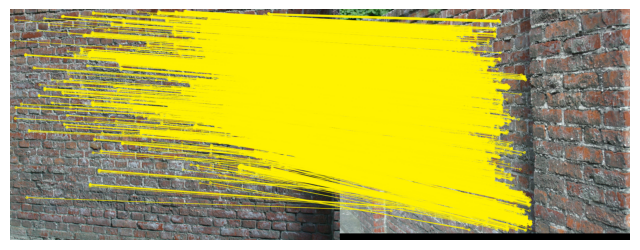

In [17]:
orig_img1 = cv2.imread(input_1)
orig_img2 = cv2.imread(input_2)

img1_rgb = cv2.cvtColor(orig_img1, cv2.COLOR_BGR2RGB)   # Convert BGR (OpenCV default) to RGB for displaying correctly with matplotlib
img2_rgb = cv2.cvtColor(orig_img2, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1_rgb)
plt.title("Original Image 1")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2_rgb)
plt.title("Original Image 2")
plt.axis('off')
plt.show()

height_1, width_1 = orig_img1.shape[:2]
height_2, width_2 = orig_img2.shape[:2]

# Resize both to 480x480 pixels
img1 = cv2.resize(orig_img1, (480, 480), interpolation=cv2.INTER_CUBIC)
img2 = cv2.resize(orig_img2, (480, 480), interpolation=cv2.INTER_CUBIC)

img_1 = Image.fromarray(img1)
img_2 = Image.fromarray(img2)

transform = T.Compose([T.ToTensor()])
input_tensor_1 = transform(img_1).unsqueeze(0).to(device)  # [1, 3, 480, 480]
input_tensor_2 = transform(img_2).unsqueeze(0).to(device)  # [1, 3, 480, 480]

with torch.no_grad():
    pred_1, pred_2 = model(input_tensor_1), model(input_tensor_2)  # [1, 1, 480, 480]
    pred_1, pred_2 = torch.sigmoid(pred_1), torch.sigmoid(pred_2)  # Converting Logits to Probabilities

threshold = model_threshold     #######################     Model's Prediction Threshold (Tau)

mask_1 = pred_1.cpu().squeeze().numpy()
mask_2 = pred_2.cpu().squeeze().numpy()
mask_1 = cv2.resize(mask_1, (width_1, height_1), interpolation=cv2.INTER_CUBIC)
mask_2 = cv2.resize(mask_2, (width_2, height_2), interpolation=cv2.INTER_CUBIC)
mask_1 = (mask_1 > threshold).astype(np.uint8)
mask_2 = (mask_2 > threshold).astype(np.uint8)

def mask_to_keypoints(mask, size=3):
    ys, xs = np.where(mask == 1)  # get coordinates of ones
    keypoints = [cv2.KeyPoint(float(x), float(y), size) for (y, x) in zip(ys, xs)]
    return keypoints

kp1_list = mask_to_keypoints(mask_1)    # Creating keypoints from masks
kp2_list = mask_to_keypoints(mask_2)

sift = cv2.SIFT_create()
kp1, des1 = sift.compute(orig_img1, kp1_list)    # Computing SIFT Descriptors for Detected Keypoints
kp2, des2 = sift.compute(orig_img2, kp2_list)    # Computing SIFT Descriptors for Detected Keypoints

print(f"Image 1: {len(kp1)} keypoints, Image 2: {len(kp2)} keypoints")
img1_kp = cv2.drawKeypoints(orig_img1, kp1, None, (0,242,255), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)
img2_kp = cv2.drawKeypoints(orig_img2, kp2, None, (0,242,255), flags=cv2.DRAW_MATCHES_FLAGS_DEFAULT)

cv2.imwrite("image_1_DEEPDETECT.png", img1_kp)
cv2.imwrite("image_2_DEEPDETECT.png", img2_kp)

img1_kp_rgb = cv2.cvtColor(img1_kp, cv2.COLOR_BGR2RGB)   # Convert BGR (OpenCV default) to RGB for displaying correctly with matplotlib
img2_kp_rgb = cv2.cvtColor(img2_kp, cv2.COLOR_BGR2RGB)

plt.figure(figsize=(8, 4))
plt.subplot(1, 2, 1)
plt.imshow(img1_kp_rgb)
plt.title("Image 1 with DeepDetect Keypoints")
plt.axis('off')
plt.subplot(1, 2, 2)
plt.imshow(img2_kp_rgb)
plt.title("Image 2 with DeepDetect Keypoints")
plt.axis('off')
plt.show()

# FLANN Matcher (KD-Tree for SIFT Descriptors)
FLANN_INDEX_KDTREE = 1
index_params = dict(algorithm=FLANN_INDEX_KDTREE, trees=5)
search_params = dict(checks=50)
flann = cv2.FlannBasedMatcher(index_params, search_params)
matches = flann.knnMatch(des1, des2, k=2)

# Nearest Neighbour Distance Ratio (NNDR) Test
good_matches = []
nndr_values = []

eps = 1e-12
for m, n in matches:
    ratio = m.distance / (n.distance + eps) # Adding eps to avoid division by zero
    nndr_values.append(ratio)
    if ratio < nndr_threshold:
        good_matches.append(m)
        
# Drawing Matches
matched_img = cv2.drawMatches(orig_img1, kp1, orig_img2, kp2, good_matches, None, matchColor=(0, 255, 0), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print(f"All NNDR Matches ({len(good_matches)} matches)")

pts1 = np.float32([kp1[m.queryIdx].pt for m in good_matches]).reshape(-1,1,2)
pts2 = np.float32([kp2[m.trainIdx].pt for m in good_matches]).reshape(-1,1,2)

if my_HOMOGRAPHY is None:
    H, mask = cv2.findHomography(pts1, pts2, cv2.RANSAC, ransacReprojThreshold=1.0, maxIters=50000)
    #F, mask = cv2.findFundamentalMat(pts1, pts2, cv2.FM_RANSAC, ransacReprojThreshold=1.0)  # Use Fundamental Matrix (Epipolar Geometry) to remove outliers - Works best for wide baseline or non-planar scenes
    mask = mask.ravel().tolist()
    inlier_matches = [m for i, m in enumerate(good_matches) if mask[i]]
else:
    threshold = my_threshold  # Pixels
    inlier_matches = []
    for i in range(len(pts1)):
        pt1_h = np.array([pts1[i,0,0], pts1[i,0,1], 1.0])    # Transform point from image 1 using H
        projected_pt1 = my_HOMOGRAPHY @ pt1_h
        projected_pt1 /= projected_pt1[2]                    # Normalize

        error = np.linalg.norm(projected_pt1[:2] - pts2[i,0])    # Calculating reprojection error
        if error < threshold:
            inlier_matches.append(good_matches[i])

img_inliers = cv2.drawMatches(orig_img1, kp1, orig_img2, kp2, inlier_matches, None, matchColor=(0,242,255), flags=cv2.DrawMatchesFlags_NOT_DRAW_SINGLE_POINTS)
print(f"Correct Matches ({len(inlier_matches)} Correspondences)")
cv2.imwrite("matches_DEEPDETECT.png", img_inliers)

plt.figure(figsize=(8,4))
plt.imshow(img_inliers[..., ::-1])
plt.axis("off")
plt.show()

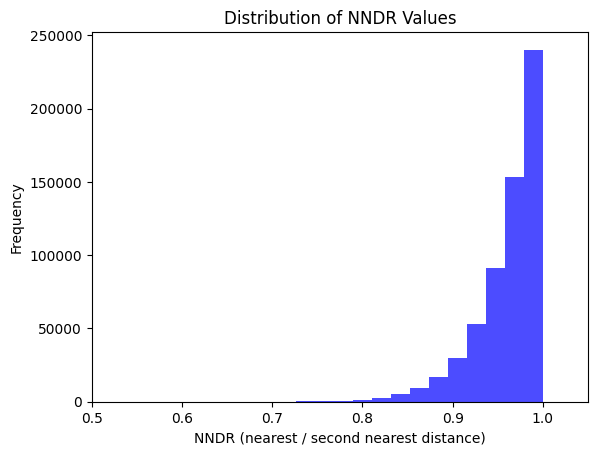

In [19]:
plt.hist(nndr_values, bins=20, color='blue', alpha=0.7)
plt.xlabel("NNDR (nearest / second nearest distance)")
plt.ylabel("Frequency")
plt.title("Distribution of NNDR Values")
plt.xlim([0.5, 1.05])
plt.show()